In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Colab Notebooks/research/data/Tea/data/images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 642 files belonging to 5 classes.


In [ ]:
class_names = dataset.class_names
class_names

['algal leaf', 'brown blight', 'greyblight_new', 'red leaf spot', 'white spot']

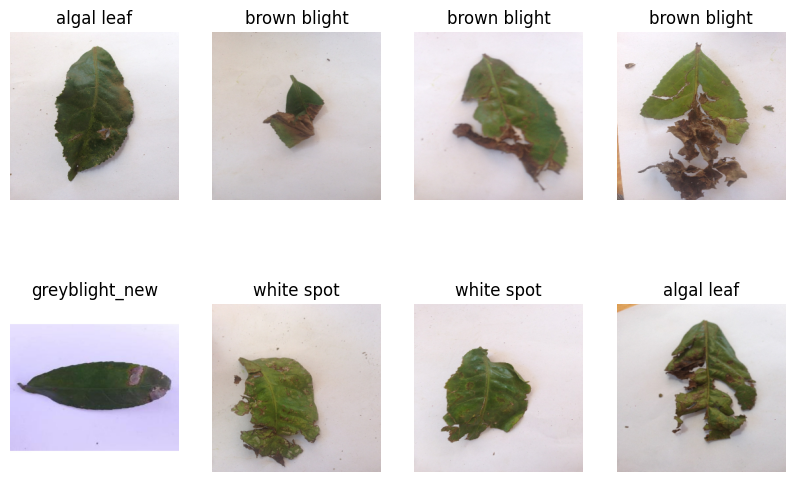

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)

    return train_ds, val_ds

In [ ]:
train_ds, val_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor='val_loss',
                                                    patience=20,
                                                    restore_best_weights=True
                                                    )
epochs=150
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/150
21/21 [==============================] - 99s 4s/step - loss: 1.6097 - accuracy: 0.2181 - val_loss: 1.5939 - val_accuracy: 0.2578
Epoch 2/150
21/21 [==============================] - 10s 417ms/step - loss: 1.5075 - accuracy: 0.3115 - val_loss: 1.3874 - val_accuracy: 0.3750
Epoch 3/150
21/21 [==============================] - 9s 361ms/step - loss: 1.3445 - accuracy: 0.4081 - val_loss: 1.2633 - val_accuracy: 0.4375
Epoch 4/150
21/21 [==============================] - 9s 331ms/step - loss: 1.2284 - accuracy: 0.4455 - val_loss: 1.8357 - val_accuracy: 0.3203
Epoch 5/150
21/21 [==============================] - 10s 403ms/step - loss: 1.1534 - accuracy: 0.4984 - val_loss: 1.5101 - val_accuracy: 0.3984
Epoch 6/150
21/21 [==============================] - 9s 370ms/step - loss: 1.2723 - accuracy: 0.4315 - val_loss: 1.0816 - val_accuracy: 0.5547
Epoch 7/150
21/21 [==============================] - 8s 317ms/step - loss: 1.0303 - accuracy: 0.5903 - val_loss: 1.0702 - val_accuracy: 0.5625

In [ ]:
#save the model
tf.keras.models.save_model(model,'/content/gdrive/MyDrive/Colab Notebooks/research/data/Tea/tea-disease-classifier.hdf5')

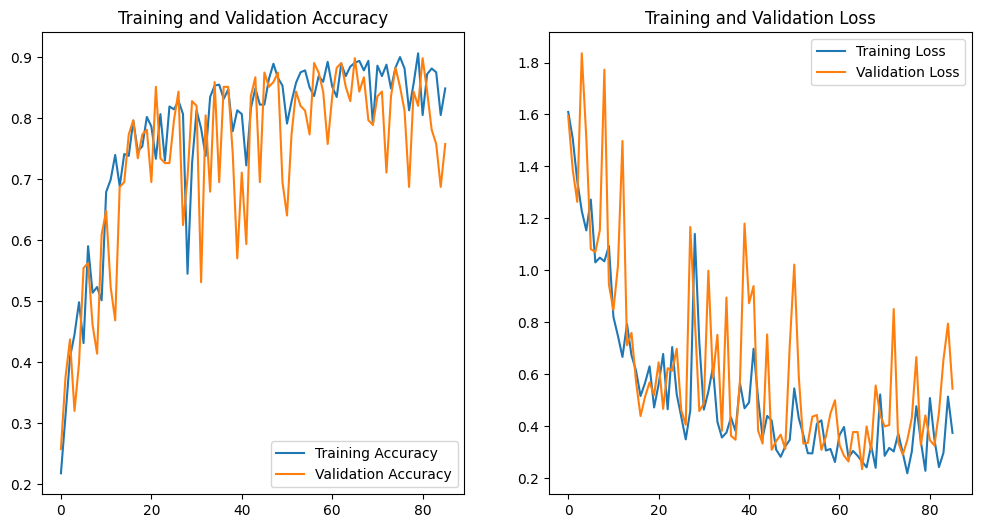

In [ ]:
# Check training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(early_stopping.stopped_epoch+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# ======        for prediction using our trained model ============================================

from matplotlib import pyplot as plt
import matplotlib.image as img
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

filepath = '/content/gdrive/MyDrive/Colab Notebooks/research/data/Tea/tea-disease-classifier.hdf5'
model = load_model(filepath)
print(model)

print("Model Loaded Successfully")

Model Loaded Successfully


In [ ]:
def predict(test_img_path):
    test_image = load_img(test_img_path, target_size = (256,256)) # load image

    test_image = img_to_array(test_image)#/255 # convert image to np array and normalize
    test_image = np.expand_dims(test_image, axis = 0)# change dimention 3D to 4D

    result = model.predict(test_image) # predict diseased palnt or not
    print(result)

    pred = np.argmax(result, axis=1)
    pred = pred[0]

    class_names = ['algal leaf', 'brown blight', 'greyblight_new', 'red leaf spot', 'white spot']

    test_image = img.imread(test_img_path)
    print(class_names[pred])
    plt.imshow(test_image)


1/1 [==============================] - 7s 7s/step
[[1.6568758e-04 2.4416056e-03 1.8527782e-06 9.6865529e-01 2.8735610e-02]]
red leaf spot


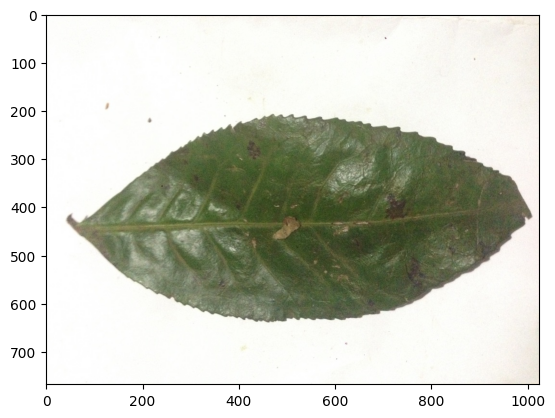

In [ ]:
predict('/content/gdrive/MyDrive/Colab Notebooks/research/data/Tea/data/images/red leaf spot/UNADJUSTEDNONRAW_thumb_177.jpg')

1/1 [==============================] - 0s 24ms/step
[[2.0520164e-04 9.8716241e-01 7.3356624e-08 7.6045114e-07 1.2631575e-02]]
brown blight


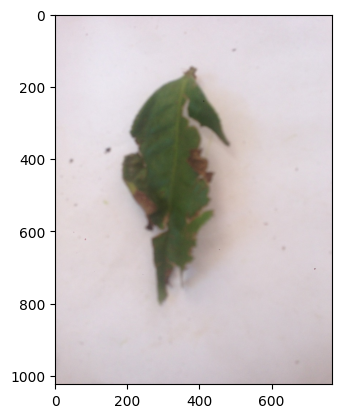

In [ ]:
predict('/content/gdrive/MyDrive/Colab Notebooks/research/data/Tea/data/images/brown blight/UNADJUSTEDNONRAW_thumb_102.jpg')

### **Evaluation**

In [ ]:
loss, accuracy = model.evaluate(dataset)

21/21 [==============================] - 39s 2s/step - loss: 0.2321 - accuracy: 0.8988


In [ ]:
y_pred = model.predict(image for image, label in val_ds)
y_pred_class = [class_names[np.argmax(pred)] for pred in y_pred]

y_val = [label for image, label in val_ds]
y_val_class = [class_names[val] for val in np.concatenate(y_val)]

4/4 [==============================] - 0s 121ms/step


In [ ]:
len(y_pred_class), len(y_val_class)

(128, 128)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_val_class, y_pred_class))
custom_cnn_report = classification_report(y_val_class, y_pred_class, output_dict=True)
print(custom_cnn_report)
print(custom_cnn_report['algal leaf']['f1-score'])

                precision    recall  f1-score   support

    algal leaf       0.50      0.50      0.50        26
  brown blight       0.53      0.70      0.60        27
greyblight_new       0.55      0.55      0.55        22
 red leaf spot       0.77      0.74      0.76        23
    white spot       0.45      0.33      0.38        30

      accuracy                           0.55       128
     macro avg       0.56      0.56      0.56       128
  weighted avg       0.55      0.55      0.55       128

{'algal leaf': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 26}, 'brown blight': {'precision': 0.5277777777777778, 'recall': 0.7037037037037037, 'f1-score': 0.6031746031746033, 'support': 27}, 'greyblight_new': {'precision': 0.5454545454545454, 'recall': 0.5454545454545454, 'f1-score': 0.5454545454545454, 'support': 22}, 'red leaf spot': {'precision': 0.7727272727272727, 'recall': 0.7391304347826086, 'f1-score': 0.7555555555555555, 'support': 23}, 'white spot': {'precisio

In [ ]:
custom_cnn_report

{'algal leaf': {'precision': 0.6153846153846154,
  'recall': 0.6153846153846154,
  'f1-score': 0.6153846153846154,
  'support': 26},
 'brown blight': {'precision': 0.5,
  'recall': 0.6666666666666666,
  'f1-score': 0.5714285714285715,
  'support': 27},
 'greyblight_new': {'precision': 0.5454545454545454,
  'recall': 0.5454545454545454,
  'f1-score': 0.5454545454545454,
  'support': 22},
 'red leaf spot': {'precision': 0.5454545454545454,
  'recall': 0.5217391304347826,
  'f1-score': 0.5333333333333332,
  'support': 23},
 'white spot': {'precision': 0.45454545454545453,
  'recall': 0.3333333333333333,
  'f1-score': 0.3846153846153846,
  'support': 30},
 'accuracy': 0.53125,
 'macro avg': {'precision': 0.5321678321678321,
  'recall': 0.5365156582547888,
  'f1-score': 0.5300432900432901,
  'support': 128},
 'weighted avg': {'precision': 0.5287642045454546,
  'recall': 0.53125,
  'f1-score': 0.5252632783882784,
  'support': 128}}

In [ ]:
import json

with open("/content/gdrive/MyDrive/Colab Notebooks/research/data/Tea/custom_cnn_report", "w") as fp:
  json.dump(custom_cnn_report, fp)

In [ ]:
print(confusion_matrix(y_val_class, y_pred_class))

[[13  4  2  3  4]
 [ 2 19  1  1  4]
 [ 3  2 12  1  4]
 [ 3  2  1 17  0]
 [ 5  9  6  0 10]]
